#  Skin Lesion Analysis Towards Melanoma Detection

---

This notebook describes the creation of a convolutinal neural network to diagnose melanoma based on images.

The data and objective are pulled from https://github.com/udacity/dermatologist-ai.

## Examine the data

Count the images and show some samples to make sure the images have been downloaded correctly.

In [1]:
import numpy as np
from glob import glob

files = np.array(glob("./data/*/*/*"))
print('There are %d total images:' % len(files))

There are 2750 total images:


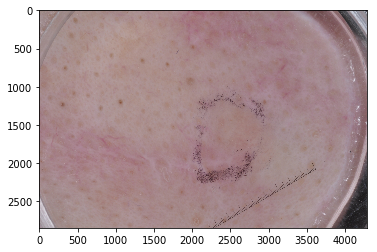

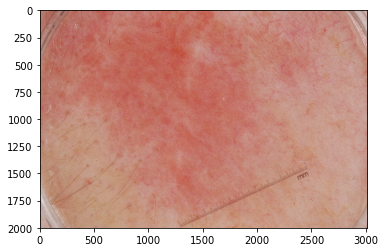

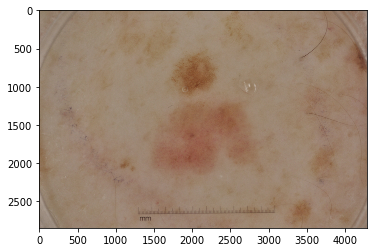

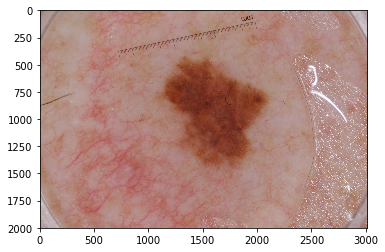

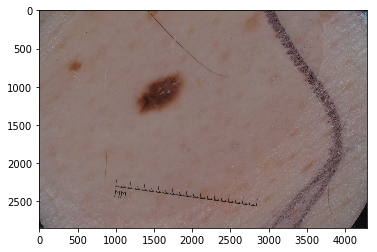

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline                               

for i in range(5):
    img = mpimg.imread(files[i])
    plt.imshow(img)
    plt.show()

## Method to load the data

Create a method to load the data. It takes the image transformations as an input parameter. This allows to conveniently evaluate the effect of different image transformations on the model performance.

In [3]:
import os
import torch
from torchvision import datasets
from torchvision import transforms

def get_data_loaders(data_dir, train_transform, test_transform, image_size, batch_size):
    train_dir = os.path.join(data_dir, 'train/')
    test_dir = os.path.join(data_dir, 'test/')
    validation_dir = os.path.join(data_dir, 'valid/')
    
    # Resize() seems to truncate images sometimes. Set LOAD_TRUNCATED_IMAGES to avoid OSError "image file is truncated"
    from PIL import ImageFile
    ImageFile.LOAD_TRUNCATED_IMAGES = True

    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)
    validation_data = datasets.ImageFolder(validation_dir, transform=test_transform)
    
    data = {
        "train": train_data,
        "test": test_data,
        "valid": validation_data
    }

    # print out some data stats
    print('Num training images: ', len(train_data))
    print('Num test images: ', len(test_data))
    print('Num validation images: ', len(validation_data))

    # define dataloader parameters
    num_workers = 0

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                               num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                              num_workers=num_workers, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, 
                                                   num_workers=num_workers, shuffle=True)

    loaders = {
        "train": train_loader,
        "test": test_loader,
        "valid": validation_loader
    }
    
    # Visualize some images
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0)).astype(np.uint8))
        
    print('\nNote: Normalization affects colors')

    return data, loaders

## Method for initializing the model

One popular technique to solve image classification problems is transfer learning. Transfer learning involves utilizing a pre-trained neural network and adapting it to a new dataset.

Pytorch provides a number of state-of-the-art pre-trained CNN models. One of them is [Inception v3](https://arxiv.org/abs/1512.00567), trained on the 1000-class Imagenet dataset. It has been applied successfully on classification of skin lesion, for example by [A. Esteva in 2017](https://www.nature.com/articles/nature21056.epdf?author_access_token=8oxIcYWf5UNrNpHsUHd2StRgN0jAjWel9jnR3ZoTv0NXpMHRAJy8Qn10ys2O4tuPakXos4UhQAFZ750CsBNMMsISFHIKinKDMKjShCpHIlYPYUHhNzkn6pSnOCt0Ftf6).

In [4]:
import torchvision.models as models

print(models.inception_v3())

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [5]:
import torch.nn as nn
from collections import OrderedDict

def init_model(pretrained, freeze_weights, number_of_classes, use_cuda):
    # instantiate a pre-trained Inception v3 model
    model = models.inception_v3(pretrained=pretrained)

    # freeze the pre-trained layers
    if freeze_weights:
        for param in model.parameters():
            param.requires_grad = False

    # remove the last fully connected layer of the pre-trained network and
    # replace it by a new, randomly initialized layer
    n_inputs = model.fc.in_features
    model.fc = nn.Linear(n_inputs, number_of_classes)

    # move model to GPU if possible
    if use_cuda:
        model = model.cuda()
        
    return model

## Methods for training the model

I want to see the model performance while training the model. 

`%matplotlib notebook` provides a interactive graph. It can be used to show the current training loss and validation loss, for example.

I need a method to initialize such a graph and another method to update the graph.

In [6]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections

def init_plot():
    fig,ax = plt.subplots(1,1)
    ax.grid(True)
    ax.set_xlabel('epoch')
    ax.legend(loc='center left') # the plot evolves to the right
    return fig, ax

def live_plot(fig, ax, data_dict, figsize=(7,5), title=''):
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(list(range(len(data_dict[line.get_label()]))))
            line.set_ydata(data_dict[line.get_label()])
        ax.set_xlim(0, len(data_dict[line.get_label()]))
        
    else:
        for label,data in data_dict.items():
            line, = ax.plot(data)
            line.set_label(label)
            ax.legend()
        ax.set_ylim(0, max(data_dict.values())[0] + 0.5)
    
    fig.canvas.draw()

In [7]:
import time
import pylab as pl
from IPython import display

def train(n_epochs, loaders, model, criterion, optimizer, scheduler, use_cuda, save_path):
    # initialize tracker for minimum validation loss
    valid_loss = 0.0
    valid_loss_min = np.Inf 
    
    losses = collections.defaultdict(list)
    fig,ax = init_plot()
    
    for epoch in range(1, n_epochs+1):
        epoch_start = time.time()
        
        scheduler.step(valid_loss)
        
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## find the loss and update the model parameters accordingly
            # clear gradients
            optimizer.zero_grad()
            
            # forward
            output = model(data)
            
            # The Inception model outputs two values: output from the last layer and the auxiliary logits.
            # Ignore the second output.
            if "Inception3" in str(type(model)):
                output = output[0]
            
            # calculate loss
            loss = criterion(output, target)
            
            # backward
            loss.backward()
            optimizer.step()
            
            ## record the average training loss, using something like
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch: {} Batch: {} \tTraining Loss: {:.6f}'.format(
                    epoch, 
                    batch_idx,
                    train_loss
                    ))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
        # plot losses
        if epoch > 1:
            losses["train"].append(train_loss.cpu())
            losses["valid"].append(valid_loss.cpu())
            live_plot(fig, ax, losses)
        
        # print training/validation statistics 
        print('Epoch: {} \t\tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tDuration: {:.6f} Min'.format(
            epoch, 
            train_loss,
            valid_loss,
            (time.time() - epoch_start) / 60.
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print("validation loss has decreased --> save the model")
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    
    # return trained model
    return model

## Method for testing the model

In [8]:
def test(loaders, model, criterion, use_cuda):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set model into evaluation mode
    model.eval()
    
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the loss
        loss = criterion(output, target)
        
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

## Create, train and test a model

### Transfer learning approaches

There are different approaches to do transfer learning. If the the size of the new dataset is small, layers of the pre-trained model can be sliced off, the weights of the remaining layers frozen and a new fully connected layer can be added. This is also referred to as feature extraction. If the the size of the new dataset is large, the pre-trained model can be fine-tuned or re-trained - depending on the similarity of the new dataset to the original training data.

Because of the relatively small amount of training data, I will use feature extaction.

### Load the data

Num training images:  2000
Num test images:  600
Num validation images:  150

Note: Normalization affects colors


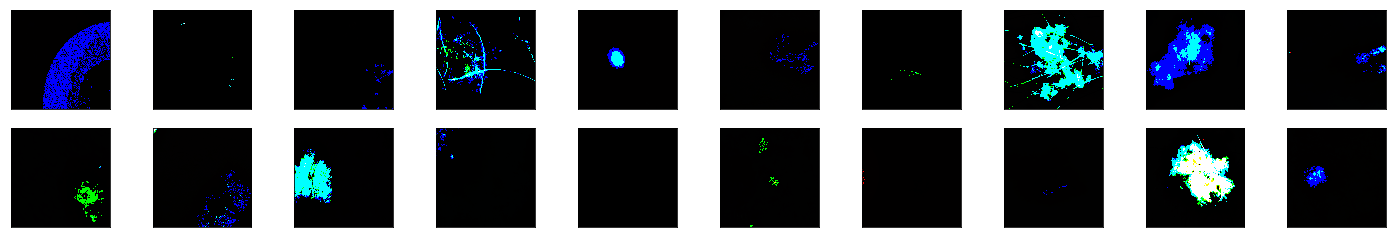

In [9]:
%matplotlib inline             

image_size=299 # inception_v3 expects tensors with a size of N x 3 x 299 x 299

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomResizedCrop((image_size, image_size)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])
                                     ])

test_transform = transforms.Compose([transforms.Resize((image_size, image_size)),
                                     transforms.RandomResizedCrop((image_size, image_size)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

data, loaders = get_data_loaders("data/", train_transform, test_transform, image_size, batch_size=20)

### Define parameters

In [13]:
# Use cuda if available
use_cuda = torch.cuda.is_available()

# model parameters
number_of_classes = len(data["train"].classes) # 3 classes: melanoma, nevus and seborrheic_keratosis

# optimization algorithm parameters
learning_rate = 0.005
epsilon = 0.1
weight_decay = 0.9
momentum = 0.9
scheduler_step_size = 8
decay_factor = 0.5

# training parameters
n_epochs = 30

In [14]:
# some imports required later on
import torch.optim as optim

In [15]:
%matplotlib notebook

### Feature extraction

In [16]:
# instantiate a pre-trained Inception v3 model and freeze the pre-trained weights
model = init_model(pretrained=True, freeze_weights=True, number_of_classes=number_of_classes, use_cuda=use_cuda)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.fc.parameters(), lr=learning_rate, eps=epsilon, weight_decay=weight_decay, 
                          momentum=momentum)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=decay_factor, patience=scheduler_step_size)

<IPython.core.display.Javascript object>


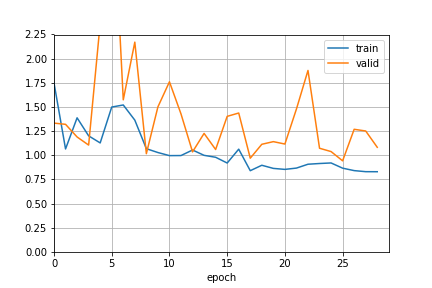

No handles with labels found to put in legend.


Epoch: 1 Batch: 0 	Training Loss: 0.950341
Epoch: 1 		Training Loss: 1.447920 	Validation Loss: 1.869917 	Duration: 4.228387 Min
validation loss has decreased --> save the model
Epoch: 2 Batch: 0 	Training Loss: 1.805475
Epoch: 2 		Training Loss: 1.748077 	Validation Loss: 1.332613 	Duration: 4.084888 Min
validation loss has decreased --> save the model
Epoch: 3 Batch: 0 	Training Loss: 1.494255
Epoch: 3 		Training Loss: 1.065363 	Validation Loss: 1.320015 	Duration: 3.986184 Min
validation loss has decreased --> save the model
Epoch: 4 Batch: 0 	Training Loss: 0.826046
Epoch: 4 		Training Loss: 1.387223 	Validation Loss: 1.189202 	Duration: 3.920816 Min
validation loss has decreased --> save the model
Epoch: 5 Batch: 0 	Training Loss: 0.810870
Epoch: 5 		Training Loss: 1.200860 	Validation Loss: 1.105460 	Duration: 3.938265 Min
validation loss has decreased --> save the model
Epoch: 6 Batch: 0 	Training Loss: 1.177071
Epoch: 6 		Training Loss: 1.127683 	Validation Loss: 2.363982 	Dura

<IPython.core.display.Javascript object>


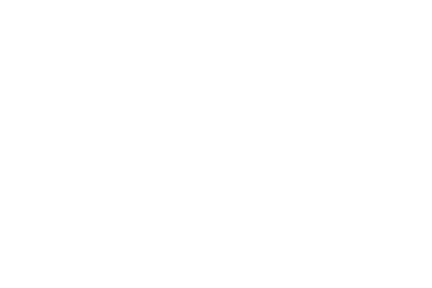

In [19]:
model = train(n_epochs, loaders, model, criterion, optimizer, scheduler, use_cuda, 
              'model_dermatologist_feature_extraction.pt')

In [20]:
# load the model that got the best validation accuracy
model.load_state_dict(torch.load('model_dermatologist_feature_extraction.pt'))

test(loaders, model, criterion, use_cuda)

Test Loss: 0.881555


Test Accuracy: 65% (395/600)


## Evaluation

The evaluation is pulled from https://github.com/udacity/dermatologist-ai. The model will be evaluated on three categories:

**Category 1: ROC AUC for Melanoma Classification**

* ability to distinguish between malignant melanoma and the benign skin lesions (nevus, seborrheic keratosis) 
* the score reflects the area under the receiver operating characteristic curve (ROC AUC) corresponding to this binary classification task

**Category 2: ROC AUC for Melanocytic Classification**

* ability to distinuish between melanocytic and keratinocytic skin lesions 
* the score reflects the area under the receiver operating characteristic curve (ROC AUC) corresponding to this binary classification task

**Category 3: Mean ROC AUC**

* the average of the ROC AUC values from the first two categories

In [21]:
%matplotlib inline

In [22]:
import csv
from PIL import Image

loader = transforms.Compose([transforms.Resize((299, 299)), transforms.ToTensor()])

def image_loader(file_name):
    image = Image.open(file_name)
    image = loader(image).float()
    #image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

def csv_dump(model, use_cuda):
    model.eval()
    
    with open("predictions.csv", mode='w') as output_file:
        writer = csv.writer(output_file, delimiter=',', lineterminator='\n', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Id', 'task_1', 'task_2'])
        
        files = np.array(glob("./data/test/*/*"))
        for file in files:
            data = image_loader(file)
            # move to GPU
            if use_cuda:
                data = data.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # task 1: the model's predicted probability that the image (at the path in Id) depicts melanoma
            p_melanoma = np.squeeze(output.data[:,0:1]).cpu().numpy()
            # task 2: the model's predicted probability that the image (at the path in Id) depicts seborrheic keratosis
            p_seborrheic_keratosis = np.squeeze(output.data[:,2:3]).cpu().numpy()
            
            writer.writerow([file.replace('\\', '/'), p_melanoma, p_seborrheic_keratosis])

csv_dump(model, use_cuda)

get_results.py:90: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_true = truth.as_matrix(columns=["task_1", "task_2"])
get_results.py:94: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])


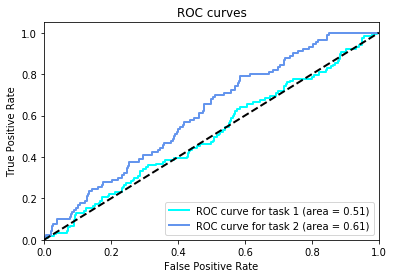

Category 1 Score: 0.508
Category 2 Score: 0.611
Category 3 Score: 0.559


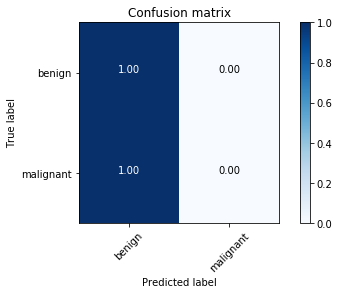

In [23]:
%run -i get_results.py predictions.csv

## Possibilities to improve the model
* Increase batch size
* Tune optimizer and scheduler parameters
* Increase number of training images
* Tune pre-processing